# t-closeness analysis for comscore panel data, stratified by race


In [1]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Set up the data

The cohorts have already been computed for 520 panels generated via a random stratified sampling on the race demographic.

Here we analyze those panels w.r.t. t-closeness, where race is the sensitive category.



In [99]:
# values of t to evaluate
T_increments = 0.005
T_max = 0.5
T = np.arange(0, T_max+T_increments, T_increments) 
## Demographic mappings
race_values = {1:'white', 2:'black', 3:'asian', 5:'other', 'any': 'any'}
print('t values:\n', T)

t values:
 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5  ]


### Read in the panel and (true) cohorts data.

In [3]:
comscore_acs_race_panels_cohorts_fpath = '../output/comscore_acs_race_panels_cohorts.csv'
all_panels_cohort_df = pd.read_csv(comscore_acs_race_panels_cohorts_fpath)
all_panels_cohort_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,191314561,1,8,1.0,1,1,275619745013456,112,121,112,99,79,69,41
1,184184131,1,10,1.0,1,1,814148202535817,343,373,343,310,255,211,116
2,188898710,1,11,1.0,1,1,720064864954915,294,319,294,265,216,183,100
3,177720627,1,9,1.0,1,1,760934312100068,321,350,321,290,237,198,108
4,222958349,1,33,1.0,1,1,1025523002764755,458,496,458,414,345,277,154


## t-closeness analysis functions


### Binomial distribution

Try estimating expected t-closeness violations with a binomial distribution.


Definition borrowed from wikipedia: https://en.wikipedia.org/wiki/Binomial_distribution#Probability_mass_function

In general, if the random variable $X$ follows the binomial distribution with parameters $n \in {\displaystyle \mathbb {N} }$  and $p \in [0,1]$, we write $X$ ~ $B(n, p)$. The probability of getting exactly $k$ successes in $n$ independent Bernoulli trials is given by the probability mass function:

${\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}}{\displaystyle f(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}}$

for k = 0, 1, 2, ..., n, where

${\displaystyle {\binom {n}{k}}={\frac {n!}{k!(n-k)!}}}$

is the binomial coefficient.


### Cumulative Distribution Function (CDF)

The CDF can be expressed as:

${\displaystyle F(k;n,p)=\Pr(X\leq k)=\sum _{i=0}^{\lfloor k\rfloor }{n \choose i}p^{i}(1-p)^{n-i},}{\displaystyle F(k;n,p)=\Pr(X\leq k)=\sum _{i=0}^{\lfloor k\rfloor }{n \choose i}p^{i}(1-p)^{n-i},}$


#### How we use binomial distributions

Consider one target t, and one race at a time. 

Use average cohort size as n.
Consider a "success" as drawing the race category for a cohort.
$p$ is then the fraction of the category in the population.

Set k such that k would violate t-closeness.

What is the probability of exceeding k? Can we compute this using the binomial CDF?


$1 - F(k, n, p) $?

This represents the expected fraction of cohorts that will violate t-closeness for a given t.

In [4]:
from scipy.stats import binom


def estimate_prob_t_closeness_violation_binomial(n, p, t):
    """
    Returns estimated expected fraction of cohorts that 
    violate t-closeness
    
    Where this is estimated by a bionomial distribution
    
    n represents cohort size (mean cohort size) for all panels
    p represents probability of drawing from category
    t is t value for t-closeness
    """
    k = n * (p + t)
    return 1 - binom.cdf(k, n, p)

First, we create a table representing $p$ for each category: the underlying, marginal distribution for race in our cohorts—this is really just the ACS marginal distribution on race. We need to set $n$, the population size, for our binomial simulation, so we calculate the average cohort size across our panels:

In [14]:
# 1. Calcualte average cohort and panel sizes for generating binomial distribution
panel_sizes = (all_panels_cohort_df
               .groupby('panel_id')
               .size()
               .rename('panel_size')
               .to_frame())

panel_sizes['avg_cohort_size'] = (all_panels_cohort_df
                                .groupby(['panel_id', 'cohort'])
                                .size()
                                .rename('size')
                                .reset_index()
                                .groupby(['panel_id'])
                                .agg({'size': [np.mean]}))

# 2. compute underlying race probabilities
race_fractions_df = (
    all_panels_cohort_df.groupby('racial_background').size()/len(all_panels_cohort_df)
).rename('fraction').to_frame()
race_fractions_df['race'] = race_fractions_df.index.map(race_values)


# get approximation of n in the binominial distribution
n = round(np.mean(panel_sizes.avg_cohort_size))
print('n = %s' % n)

n = 52


Using the binomial CDF, we calculate the expected t-closeness violations by t value and race category. These values can be directly compared to the empirical data we've computed to test whether we see more t-closeness violations than we expect given population sizes.

In [128]:
# calculate estimated violations for each t
est_t_violations_df = pd.DataFrame({'t': T})
for (race, p) in race_fractions_df.set_index('race')['fraction'].items():
    est = lambda t: estimate_prob_t_closeness_violation_binomial(n, p, t)
    est_t_violations_df[race] = est_t_violations_df['t'].apply(est)

est_t_violations_df.set_index('t', inplace=True)

#fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
#plt.tight_layout()
#for i, cat in enumerate(est_t_violations_df.columns):
#    ax = axes[i]
#    ax.plot(est_t_violations_df[cat])
#    ax.set_title(cat)
#    ax.set_xlabel('t (of t-closeness)')
    
#_ = axes[0].set_ylabel('fraction expected violation')

# Plotting binomial simulation against empirical data

In [22]:
def aggregate_t_closeness_violations(df, 
                                     demo_col='racial_background',
                                     values_map=race_values):
    return (df
        .groupby(['t', demo_col])
        .agg({'fraction_violate': [np.mean, 
               lambda x: np.mean(x) + 1.96*np.std(x),
               lambda x: np.mean(x) - 1.96*np.std(x)]})
        .set_axis(['fraction_violate', 'upper', 'lower'], axis=1, inplace=False)
        .reset_index()
)

In [19]:
all_panels_cohort_df.head(3)

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,191314561,1,8,1.0,1,1,275619745013456,112,121,112,99,79,69,41
1,184184131,1,10,1.0,1,1,814148202535817,343,373,343,310,255,211,116
2,188898710,1,11,1.0,1,1,720064864954915,294,319,294,265,216,183,100


In [20]:
start_time = datetime.now()
print('%s - computing t-closeness for all panels' % start_time)
all_panels_t_closeness_df = panels_t_closeness(
    all_panels_cohort_df
)
end_time = datetime.now()
time = end_time - start_time
print('%s - time: %s' % (end_time, time))
all_panels_t_closeness_df.head()

2022-01-21 11:29:51.975164 - computing t-closeness for all panels
computing t-closeness for 520 panels
2022-01-21 11:44:25.827248 - time: 0:14:33.852084


,racial_background,fraction_violate,t,panel_id
0,1.0,0.499006,0.0,1
1,2.0,0.475149,0.0,1
2,3.0,0.451292,0.0,1
3,5.0,0.475149,0.0,1
0,any,1.000000,0.0,1


In [82]:
# align and merge simulated and empirical data

agg_t_closeness_df = aggregate_t_closeness_violations(
    all_panels_t_closeness_df,
    demo_col='racial_background', values_map=race_values
)
agg_t_closeness_df['race'] = agg_t_closeness_df['racial_background'].map(race_values)

simulated_violations_df = (est_t_violations_df
 .reset_index()
 .melt(id_vars=['t'], 
       var_name='race', 
       value_name='fraction_violate')
 .assign(kind='Simulated')
)

plot_df = pd.concat([simulated_violations_df,
                    (agg_t_closeness_df
                     .assign(kind='Empirical')
                     .drop('racial_background', axis=1))])

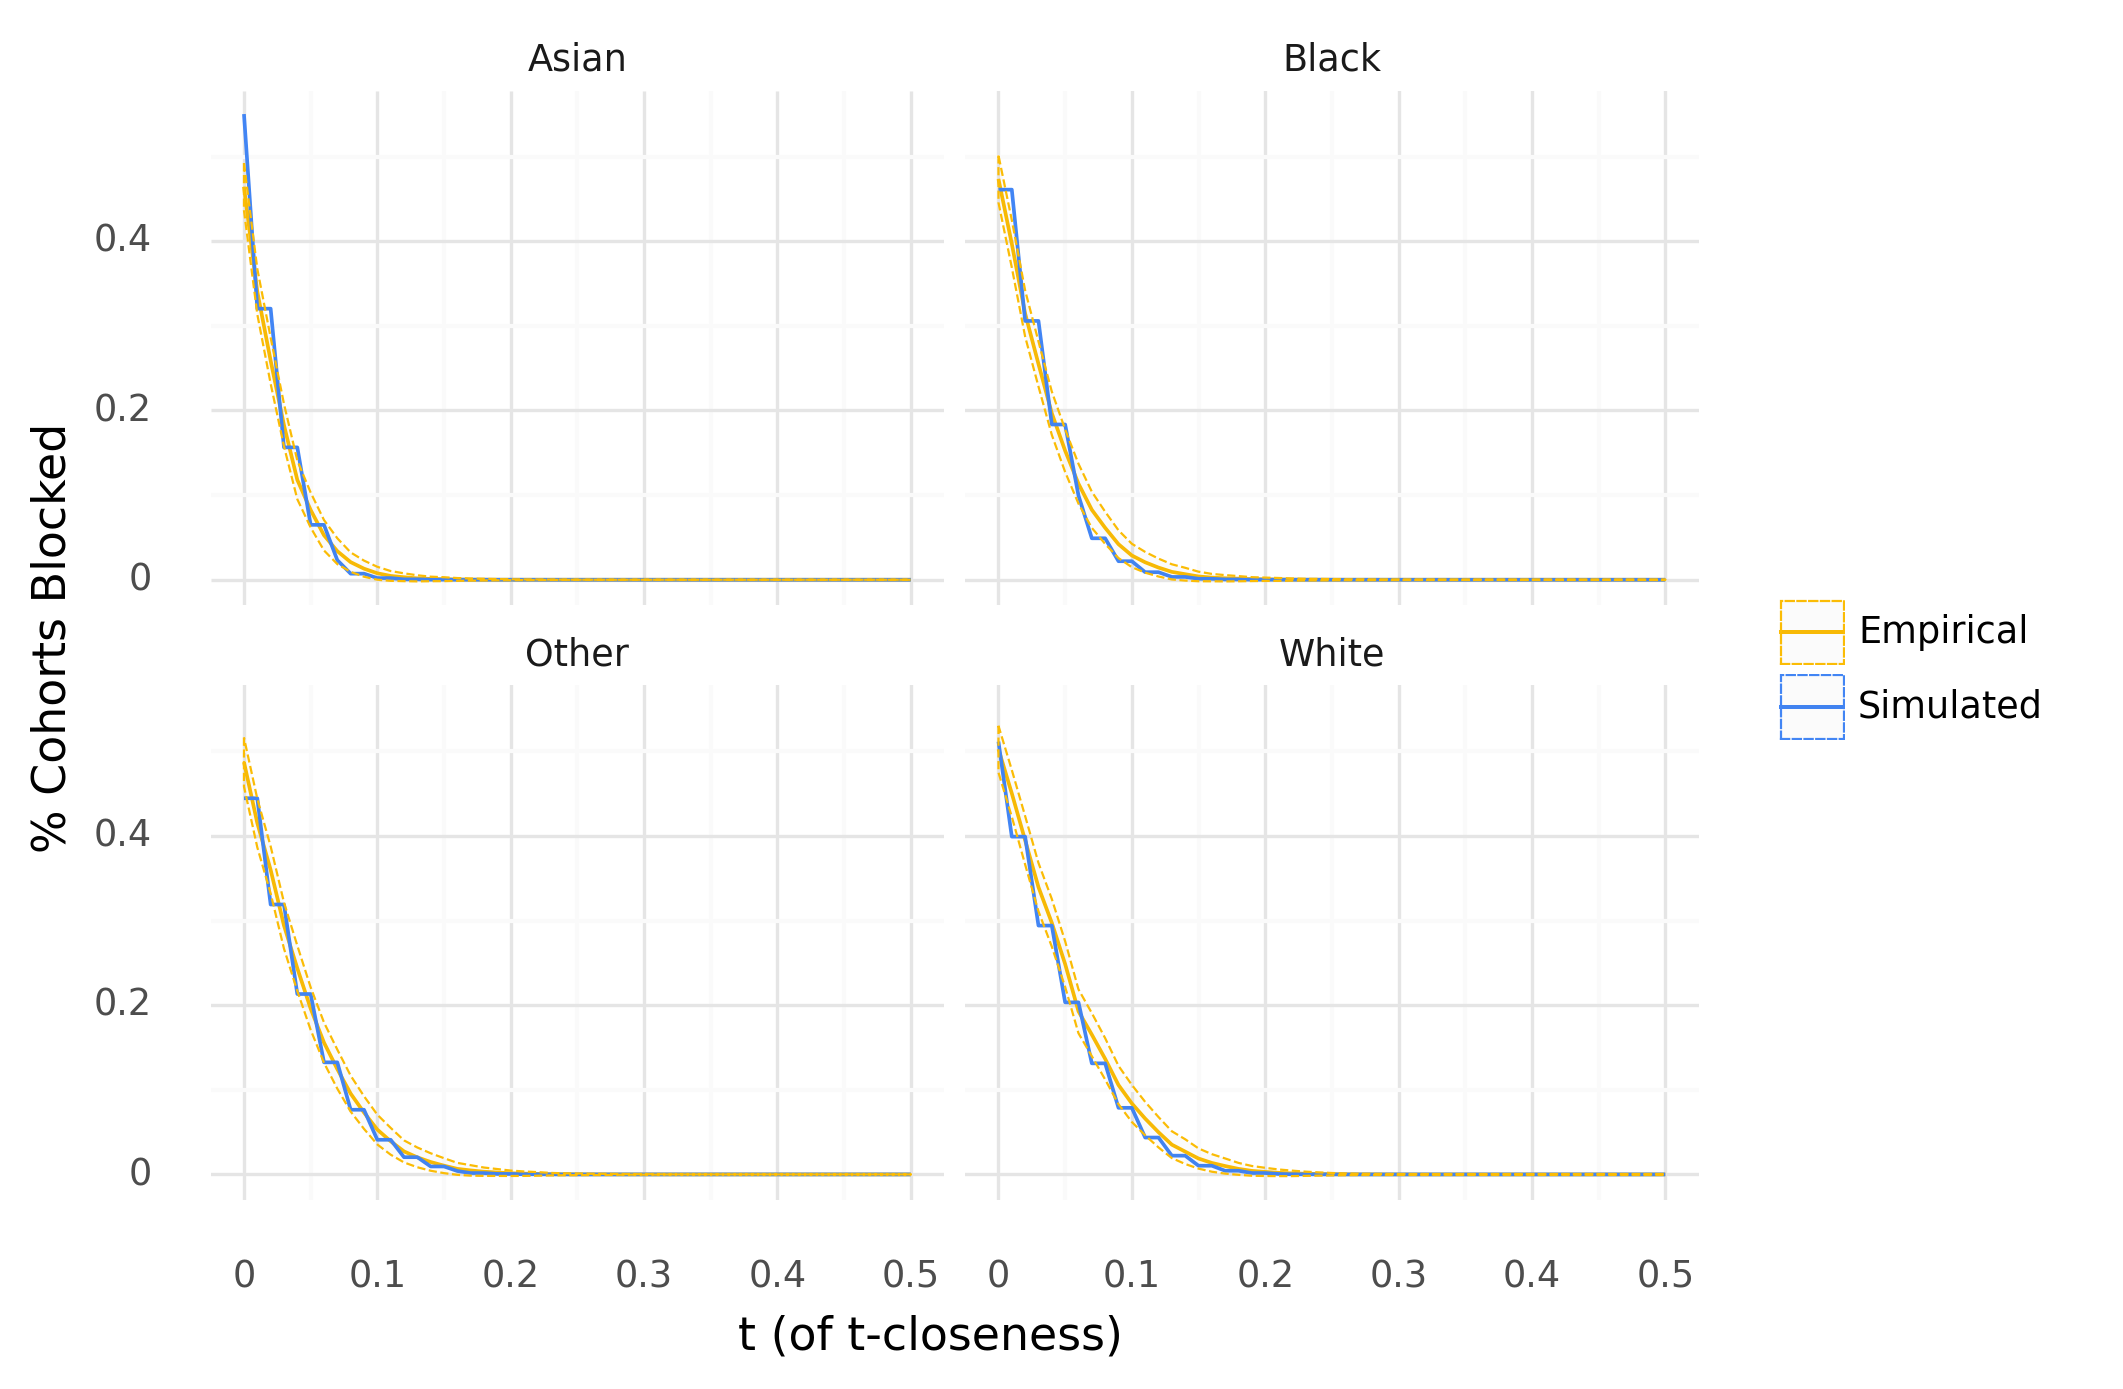

<ggplot: (344953604)>

In [98]:
from plotnine import (ggplot, geom_point, aes, stat_smooth, 
                      facet_wrap, geom_bar, element_text, 
                      theme, theme_minimal, labs, element_blank, 
                      element_line, geom_path, geom_ribbon, scale_color_manual)
from style_config import RED, BLUE, GREEN, ORANGE

(plot_df
 .query("race != 'any'")
 .assign(race=lambda x: x.race.map(lambda x: x.capitalize()))
 .pipe(lambda df:
     ggplot(df, aes(x='t', y='fraction_violate', color='kind')) +
     geom_path() +      
     geom_ribbon(aes(x='t', ymin='lower', ymax='upper', color='kind'), 
                 alpha=0.02, linetype='dashed', size=0.3) +
     facet_wrap("~race") +
     theme_minimal() +
       labs(x="t (of t-closeness)",
           y='% Cohorts Blocked',
           color="") +
       theme(
           #legend_position='bottom',
           dpi=300) +
       scale_color_manual(values=[ORANGE,BLUE,RED, GREEN])
    )
)

---
No longer use the below?

In [17]:
def get_cohort_demo_fractions_df(panel_df, cohort_name='cohort', 
                                demo_col='racial_background'):
    """
    Returns a dataframe with columns
    cohort, demo_col, count, total, fraction
    """
    df = panel_df.groupby(
        [cohort_name, demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby(cohort_name).count()['panel_id']
    df['fraction'] = df['count']/df['total']
    return df


def calculate_violates(df, t, demo_fractions, 
                         demo_col='racial_background'):
    """
    Calculates for each cohort in `df` whether t-closeness
    is violated for given t.
    
    This is true when the cohort population's frequency
    for a category is at least `t` greater than the base 
    population frequency.
    
    Each row in `df` is a cohort.
    """
    return (df
          .assign(population_fraction = lambda x: x[demo_col].map(demo_fractions))
          .assign(t = lambda x: x.fraction - x.population_fraction)
          .assign(violate = lambda x: x.t >= t))


def calculate_fraction_violate(panel_df, t, demo_col='racial_background'):
    cohort_demo_fractions_df = get_cohort_demo_fractions_df(panel_df)
    demo_fractions = panel_df.groupby(
        demo_col
    )['panel_id'].count() / len(panel_df)
    
    any_violated = (cohort_demo_fractions_df
     .pipe(calculate_violates, t=t, demo_fractions=demo_fractions)
     .reset_index()
     .assign(n_cohorts = lambda x: x.cohort.nunique())
     .groupby('cohort')
     .agg({'violate': lambda x: sum(x) > 0})
                    ).pipe(lambda df: df.violate.sum() / len(df))
    any_violate_df = pd.DataFrame({demo_col: ['any'],
                                 'fraction_violate': [any_violated],
                                 't': [t]})

    return (cohort_demo_fractions_df
            .pipe(calculate_violates, t=t, demo_fractions=demo_fractions)
            .reset_index()
            # calculate fraction of cohorts, grouped by demo, that violate for t.
            .assign(n_cohorts = lambda x: x.cohort.nunique())
            .groupby([demo_col])
            .apply(lambda x: sum(x.violate) / x.n_cohorts)
            .reset_index()
            # becuase we use `apply` above, drop duplicates to get only demo_col, fraction_violates
            [[demo_col, 'n_cohorts']]
            .drop_duplicates()
            .rename(columns={'n_cohorts': 'fraction_violate'})
            .reset_index(drop=True)
            .assign(t=t)
            # then, concatenate with our any_violate_df with a demo_col of `any`
            ).pipe(lambda df: pd.concat([df, any_violate_df]))


def panel_t_closeness(panel_df, demo_col='racial_background', T=T):
    """
    Calculates t-closeness violations for a range of t values for a 
    given demographic column and panel dataframe.
    
    Returns a dataframe with the following columns
        demo_col, fraction_violate, t
    """
    return pd.concat(
        [calculate_fraction_violate(panel_df, demo_col=demo_col, t=t) for t in T]
    )

def panels_t_closeness(panels_df, demo_col='racial_background', 
                           T=T, panel_ids=None):
    if panel_ids is None:
        panel_ids = panels_df.panel_id.unique()
    print('computing t-closeness for %s panels' % (len(panel_ids)))
    panels = [panels_df[panels_df.panel_id == panel_id] for panel_id in panel_ids]
    t_closeness_dfs = [panel_t_closeness(panel, demo_col=demo_col, T=T).assign(panel_id=panel_id) for panel, panel_id in zip(panels, panel_ids)]
    return pd.concat(t_closeness_dfs)


Calculate t-closeness for all $t \in T$, for each category, for each panel.

How long should this take?
Test with subset of panel ids.

In [51]:
P_subset = 10

panel_ids = all_panels_random_cohort_df.panel_id.unique()[:P_subset]

start_time = datetime.now()
panels_t_closeness_subset_df = panels_t_closeness(
    all_panels_random_cohort_df, panel_ids=panel_ids
)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s panels' % (time, P_subset))

print('expect to take %s for all panels' % (
    (all_panels_random_cohort_df.panel_id.nunique()/P_subset * time)
))
panels_t_closeness_subset_df.head()

computing t-closeness for 10 panels
took 0:00:12.635773 for 10 panels
expect to take 0:10:57.060196 for all panels


,racial_background,fraction_violate,t,panel_id
0,1.0,0.498998,0.0,1
1,2.0,0.466934,0.0,1
2,3.0,0.474950,0.0,1
3,5.0,0.482966,0.0,1
0,any,1.000000,0.0,1


In [32]:
all_panels_random_cohorts_t_closeness_df = panels_t_closeness(
    all_panels_random_cohort_df
)
all_panels_random_cohorts_t_closeness_df.head()

,racial_background,fraction_violate,t,panel_id
0,1.0,0.498998,0.0,1
1,2.0,0.466934,0.0,1
2,3.0,0.474950,0.0,1
3,5.0,0.482966,0.0,1
0,any,1.000000,0.0,1


In [103]:
def aggregate_t_closeness_violations(df, 
                                     demo_col='racial_background',
                                     values_map=race_values):
    return (df
        .groupby(['t', demo_col])
        .agg({'fraction_violate': [np.mean, 
               lambda x: np.mean(x) + 1.96*np.std(x),
               lambda x: np.mean(x) - 1.96*np.std(x)]})
        .set_axis(['fraction_violate', 'upper', 'lower'], axis=1, inplace=False)
        .reset_index()
)

##### Plotting

In [116]:
agg_t_closeness_random_cohorts_df = aggregate_t_closeness_violations(
    all_panels_random_cohorts_t_closeness_df,
    demo_col='racial_background', values_map=race_values
)
agg_t_closeness_random_cohorts_df['race'] = agg_t_closeness_random_cohorts_df['racial_background'].map(race_values)
agg_t_closeness_random_cohorts_df.head()

,t,racial_background,fraction_violate,upper,lower,race
0,0.0,1.0,0.501500,0.529894,0.473106,white
1,0.0,2.0,0.474308,0.502043,0.446572,black
2,0.0,3.0,0.467435,0.495057,0.439812,asian
3,0.0,5.0,0.488520,0.516934,0.460106,other
4,0.0,any,1.000000,1.000000,1.000000,any


## Appendix: Binomial models mimic random cohort data

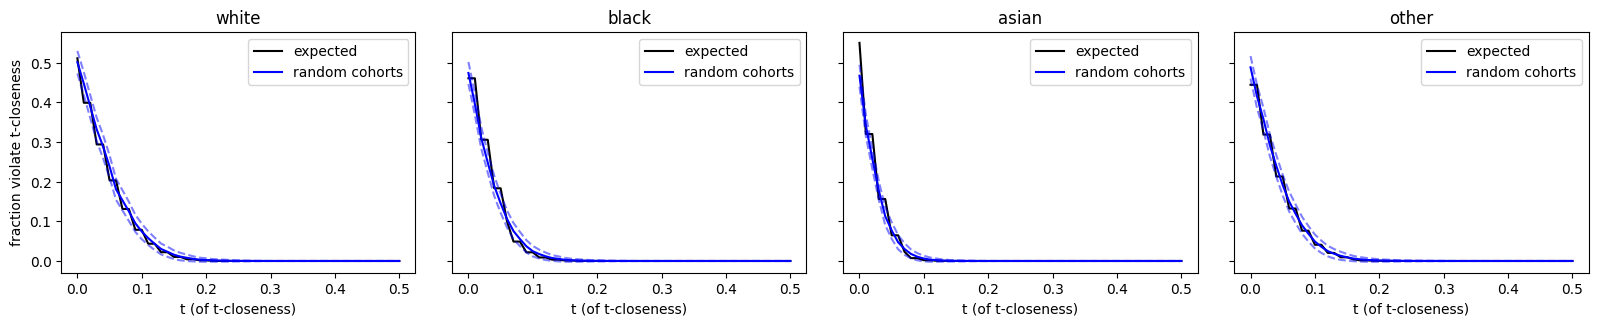

In [117]:
df = agg_t_closeness_random_cohorts_df

fig, axes = plt.subplots(1, 4, figsize=(4*4, 3), dpi=100, sharey=True)
plt.tight_layout()
for i, race in enumerate(['white','black','asian','other']):
    ax = axes[i]
    expected = est_t_violations_df[race]
    ax.plot(expected, label='expected', color='black')
    
    random_cohorts_mean = df[df['race']==race].set_index('t')['fraction_violate']
    ax.plot(random_cohorts_mean, label='random cohorts', color='blue')
    # plot confidence intervals
    random_cohorts_upper = df[df['race']==race].set_index('t')['upper']
    random_cohorts_lower = df[df['race']==race].set_index('t')['lower']
    ax.plot(random_cohorts_upper, '--', color='blue', alpha=0.5)
    ax.plot(random_cohorts_lower, '--', color='blue', alpha=0.5)

    ax.set_title(race)
    ax.set_xlabel('t (of t-closeness)')
    ax.legend()

_ = axes[0].set_ylabel('fraction violate t-closeness')

The expected values based on the binomial distribution closely match the empirical data for the randomly assigned cohorts data.

We use this as validation that we can use the binomial distribution CDF to estimate expected t-closeness violations.

Look at 'any' category violation.

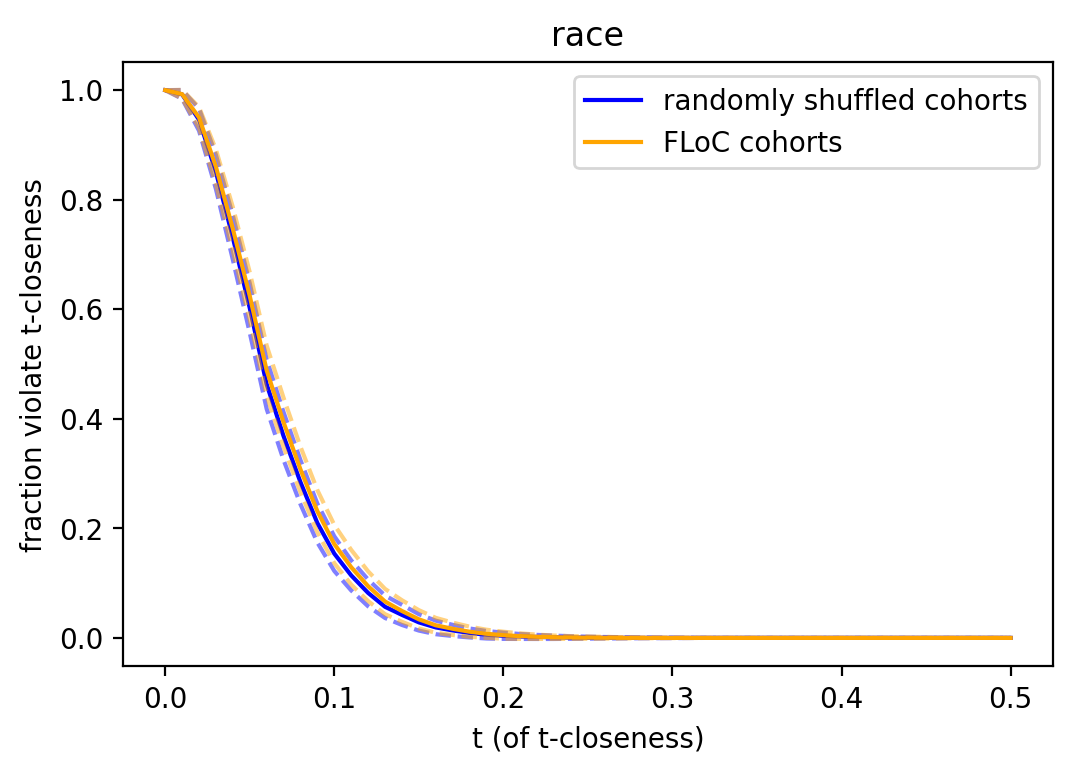

In [133]:
dpi=200
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=dpi, sharey=True)

race = 'any'

labeled_dfs = [
    # (label, color, df)
    ('randomly shuffled cohorts', 'blue', agg_t_closeness_random_cohorts_df),
    ('FLoC cohorts', 'orange', agg_t_closeness_df)
]
for (label, color, df) in labeled_dfs:

    mean = df[df['race']==race].set_index('t')['fraction_violate']
    ax.plot(mean, label=label, color=color)
    # plot confidence intervals
    upper = df[df['race']==race].set_index('t')['upper']
    lower = df[df['race']==race].set_index('t')['lower']
    ax.plot(upper, '--', alpha=0.5, color=color)
    ax.plot(lower, '--', alpha=0.5, color=color)

    ax.set_title('race')
    ax.set_xlabel('t (of t-closeness)')
    ax.legend()

_ = ax.set_ylabel('fraction violate t-closeness')

The t-closeness violations for the FLoC cohorts data fall within the CI's for the randomly shuffled cohorts data.

# Appendix

## Binomial CDF mirrors randomly shuffled cohort data

Here, we check that the binomial CDF representation matches if we simulated cohorts by shuffling simhashes:

### Read in the panel and random cohorts comparison data.

In [4]:
comscore_acs_race_panels_randomly_shuffled_simhash_cohorts_fpath = '../output/comscore_acs_race_panels_randomly_shuffled_simhash_cohorts.csv'
all_panels_random_cohort_df = pd.read_csv(comscore_acs_race_panels_randomly_shuffled_simhash_cohorts_fpath)
all_panels_random_cohort_df.head()

,machine_id,week,racial_background,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,1.0,1,1090102657990507,485,521,485,448,384,302,164
1,225562713,1,1.0,1,1019338229492379,447,479,447,414,356,278,152
2,193448730,1,1.0,1,734410134560674,297,322,297,273,231,178,103
3,216306558,1,1.0,1,678452071939058,265,286,265,244,204,162,93
4,223440886,1,1.0,1,1030473222958166,456,488,456,423,362,283,155


When we do this analysis we make some assumptions that we first check here.

1. The true and comparison panel cohorts data are indeed good comparisons: We check this by comparing the average cohort sizes per panel.

2. The expected fraction of cohorts that violate t-closeness for a given category (for each panel) can be approximated by a binomial distribution based on cohort sizes, t, and the fraction of the population in the category: We calculate the expected value estimates for each panel and compare to the randomly shuffled simhash comparison data.

### Panel size comparison
dc - No longer needed for appendix (imo) but kept for posterity

In [8]:
def compare_panel_cohort_sizes(true_df, other_df, 
                               other_avg_cohort_size_name):
    """
    Returns a dataframe with columns
    panel_id, panel_size, avg_cohort_size, other_avg_cohort_size_name
    
    where:
        - the input dfs have same panel ids but different 
        cohort assignments
        - avg_cohort_size, other_avg_cohort_size_name represent 
        mean cohort size for given panel_id
    """
    panel_sizes = true_df.groupby(
        'panel_id'
    ).size().rename('panel_size').to_frame()
    panel_sizes['avg_cohort_size'] = true_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    panel_sizes[other_avg_cohort_size_name] = other_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    return panel_sizes

,panel_size,avg_cohort_size,avg_randomly_shuffled_simhash_cohort_size
panel_id,,,
291,21152,51.590244,52.616915
83,21152,50.846154,51.843137
135,21152,50.482100,53.549367


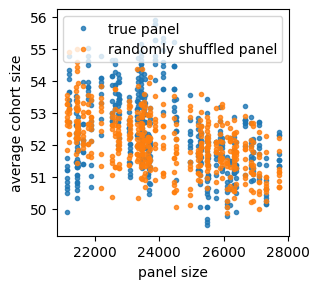

In [6]:
other_avg_cohort_size_name = 'avg_randomly_shuffled_simhash_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df,
    all_panels_random_cohort_df, 
    other_avg_cohort_size_name)

# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly shuffled panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

panel_sizes_sorted.head(3)